# Análise de Fairness - DI/SPD

Este notebook realiza a análise de fairness dos modelos de detecção de fake news, calculando métricas de Demographic Parity (DI) e Statistical Parity Difference (SPD) e gerando visualizações para o relatório.

In [1]:
# Importações necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display

# Configuração de visualização
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

print("Notebook de Análise de Fairness - Iniciado")
print("="*50)

Notebook de Análise de Fairness - Iniciado


## 1. Carregamento dos Dados Pré-processados

Carregar os dados que foram processados no notebook 01.

In [2]:
# Carregar dados pré-processados
print("Carregando dados pré-processados do notebook 01...")

# Verificar se os dados existem (arquivo com as novas colunas)
data_path = "../data/processed/fakebr_with_labels.csv"

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print(f"Dados carregados: {df.shape[0]} amostras x {df.shape[1]} colunas")
    
    # Verificar colunas essenciais
    required_cols = ['categoria', 'classificacao', 'REAL', 'label_texto']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        print(f"Colunas essenciais faltando: {missing_cols}")
        print("Execute primeiro o notebook 01_preprocess_fakebr.ipynb")
    else:
        print("Todas as colunas essenciais presentes")
        
        # Resumo dos dados
        print(f"\nDistribuição de classes:")
        print(df['label_texto'].value_counts())
        print(f"\nCategorias disponíveis: {df['categoria'].nunique()}")
        print(df['categoria'].value_counts().head())
        
else:
    print(f"Arquivo não encontrado: {data_path}")
    print("Execute primeiro o notebook 01_preprocess_fakebr.ipynb")

Carregando dados pré-processados do notebook 01...
Dados carregados: 7200 amostras x 29 colunas
Todas as colunas essenciais presentes

Distribuição de classes:
label_texto
fake    3600
real    3600
Name: count, dtype: int64

Categorias disponíveis: 6
categoria
politica               4180
tv_celebridades        1544
sociedade_cotidiano    1276
ciencia_tecnologia      112
economia                 44
Name: count, dtype: int64
Dados carregados: 7200 amostras x 29 colunas
Todas as colunas essenciais presentes

Distribuição de classes:
label_texto
fake    3600
real    3600
Name: count, dtype: int64

Categorias disponíveis: 6
categoria
politica               4180
tv_celebridades        1544
sociedade_cotidiano    1276
ciencia_tecnologia      112
economia                 44
Name: count, dtype: int64


## 2. Análise de Viés por Categoria

Esta seção analisa se existe viés na distribuição de fake news entre diferentes categorias jornalísticas. Isso é fundamental para entender se o modelo pode ter comportamentos diferentes para temas específicos.

In [3]:
print("Explorando a distribuição por categoria")
print("="*50)

# Análise das categorias
print(f"Categorias únicas: {df['categoria'].nunique()}")
print(f"\nDistribuição de amostras por categoria:")
categoria_counts = df['categoria'].value_counts()
print(categoria_counts)

# Tabela cruzada para ver a distribuição de fake vs real por categoria
print("\nTabela Cruzada: Categoria vs Label")
print("="*50)

tabela_cruzada = pd.crosstab(df['categoria'], df['label_texto'])
print(tabela_cruzada)

print("\nProporções por categoria (%):")
proporcoes = pd.crosstab(df['categoria'], df['label_texto'], normalize='index') * 100
print(proporcoes.round(2))

Explorando a distribuição por categoria
Categorias únicas: 6

Distribuição de amostras por categoria:
categoria
politica               4180
tv_celebridades        1544
sociedade_cotidiano    1276
ciencia_tecnologia      112
economia                 44
religiao                 44
Name: count, dtype: int64

Tabela Cruzada: Categoria vs Label
label_texto          fake  real
categoria                      
ciencia_tecnologia     56    56
economia               22    22
politica             2090  2090
religiao               22    22
sociedade_cotidiano   638   638
tv_celebridades       772   772

Proporções por categoria (%):
label_texto          fake  real
categoria                      
ciencia_tecnologia   50.0  50.0
economia             50.0  50.0
politica             50.0  50.0
religiao             50.0  50.0
sociedade_cotidiano  50.0  50.0
tv_celebridades      50.0  50.0


Visualização do Viés por Categoria


<Figure size 1200x600 with 0 Axes>

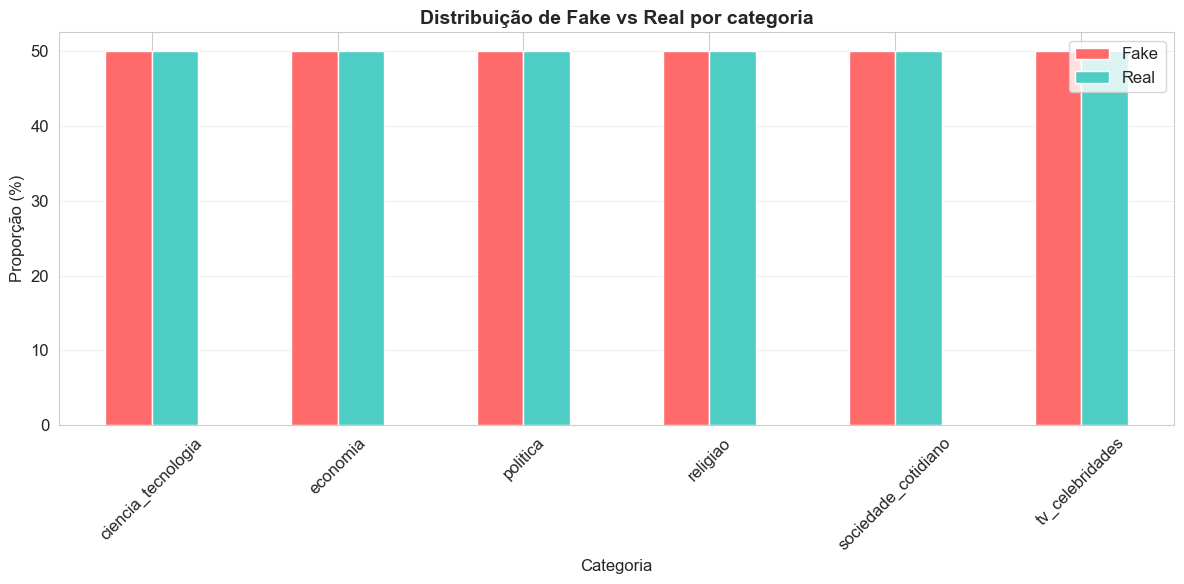

In [4]:
# Visualização do Viés por Categoria
print("Visualização do Viés por Categoria")
print("="*50)

plt.figure(figsize=(12,6))

proporcoes.plot(kind='bar', color=['#ff6b6b', '#4ecdc4'])
plt.title("Distribuição de Fake vs Real por categoria", fontsize=14, fontweight='bold')
plt.xlabel('Categoria', fontsize=12)
plt.ylabel('Proporção (%)', fontsize=12)
plt.legend(['Fake','Real'])
plt.xticks(rotation=45) # Roda os nomes das categorias para caber melhor
plt.grid(axis='y', alpha=0.3) # Adiciona linhas de grade horizontais
plt.tight_layout()
plt.show()

## 3. Cálculo das Métricas de Fairness

**Statistical Parity Difference (SPD)**: Mede se diferentes grupos (categorias) têm a mesma probabilidade de receber um resultado positivo.

**Disparate Impact (DI)**: Mede a razão entre as taxas de resultados positivos de diferentes grupos. É uma métrica multiplicativa (ao contrário do SPD que é aditivo).

OBS: como usamos fake como “evento”, o DI>1 indica maior taxa de fake naquela categoria do que no geral (e DI<1 indica menor). Isso é consistente com o SPD.

In [5]:
# Calcular métricas de fairness por categoria
print("Métricas de Fairness por Categoria")
print("="*60)

# Calcular Statistical Parity Difference (SPD) para cada categoria
print("Statistical Parity Difference (SPD):")
print("SPD = P(Y=1|categoria) - P(Y=1|geral)")
print("Valores próximos de 0 = justo, valores distantes = viés")
print("-" * 40)

# Taxa geral de fake news (baseline)
taxa_geral_fake = (df['label_texto'] == 'fake').mean()
print(f"Taxa geral de fake news: {taxa_geral_fake:.3f} ({taxa_geral_fake*100:.1f}%)")

print("\nSPD por categoria:")
spd_resultados = {}

for categoria in df['categoria'].unique():
    # Filtrar dados da categoria
    dados_categoria = df[df['categoria'] == categoria]
    
    # Taxa de fake news nesta categoria
    taxa_categoria_fake = (dados_categoria['label_texto'] == 'fake').mean()
    
    # Calcular SPD
    spd = taxa_categoria_fake - taxa_geral_fake
    spd_resultados[categoria] = spd
    
    # Status do viés
    if abs(spd) < 0.1:
        status = "Justo"
    elif abs(spd) < 0.2:
        status = "Viés Moderado"
    else:
        status = "Viés Alto"
    
    print(f"{categoria:15}: SPD = {spd:+.3f} ({taxa_categoria_fake*100:5.1f}% fake) - {status}")

Métricas de Fairness por Categoria
Statistical Parity Difference (SPD):
SPD = P(Y=1|categoria) - P(Y=1|geral)
Valores próximos de 0 = justo, valores distantes = viés
----------------------------------------
Taxa geral de fake news: 0.500 (50.0%)

SPD por categoria:
politica       : SPD = +0.000 ( 50.0% fake) - Justo
tv_celebridades: SPD = +0.000 ( 50.0% fake) - Justo
sociedade_cotidiano: SPD = +0.000 ( 50.0% fake) - Justo
ciencia_tecnologia: SPD = +0.000 ( 50.0% fake) - Justo
economia       : SPD = +0.000 ( 50.0% fake) - Justo
religiao       : SPD = +0.000 ( 50.0% fake) - Justo


In [6]:
print("\n" + "="*60)
print("Disparate Impact (DI):")
print("DI = P(Y=1|categoria) / P(Y=1|geral)")
print("Valores próximos de 1.0 = justo, distantes = viés")
print("-" * 40)

print("\nDI por categoria:")
di_resultados = {}

for categoria in df['categoria'].unique():
    # Filtrar dados da categoria
    dados_categoria = df[df['categoria'] == categoria]
    
    # Taxa de fake news nesta categoria
    taxa_categoria_fake = (dados_categoria['label_texto'] == 'fake').mean()
    
    # Calcular DI (evitar divisão por zero)
    if taxa_geral_fake > 0:
        di = taxa_categoria_fake / taxa_geral_fake
    else:
        di = float('inf')
    
    di_resultados[categoria] = di
    
    # Status do viés (regra 80/20)
    if 0.8 <= di <= 1.25:
        status = "Justo"
    elif 0.5 <= di < 0.8 or 1.25 < di <= 2.0:
        status = "Viés Moderado"
    else:
        status = "Viés Alto"
    
    print(f"{categoria:15}: DI = {di:.2f} ({taxa_categoria_fake*100:5.1f}% fake) - {status}")


Disparate Impact (DI):
DI = P(Y=1|categoria) / P(Y=1|geral)
Valores próximos de 1.0 = justo, distantes = viés
----------------------------------------

DI por categoria:
politica       : DI = 1.00 ( 50.0% fake) - Justo
tv_celebridades: DI = 1.00 ( 50.0% fake) - Justo
sociedade_cotidiano: DI = 1.00 ( 50.0% fake) - Justo
ciencia_tecnologia: DI = 1.00 ( 50.0% fake) - Justo
economia       : DI = 1.00 ( 50.0% fake) - Justo
religiao       : DI = 1.00 ( 50.0% fake) - Justo


## 4. Resumo e Visualização das Métricas

In [7]:
print("Resumo Visual das Métricas de Fairness")
print("="*50)

# Criar dataframe com os resultados
fairness_df = pd.DataFrame({
    'SPD': spd_resultados,
    'DI': di_resultados
})

# Identificando categorias problemáticas
print("Categorias com viés alto:")
for categoria in fairness_df.index:
    spd_val = fairness_df.loc[categoria, 'SPD']
    di_val = fairness_df.loc[categoria, 'DI']
    
    problemas = []
    if abs(spd_val) >= 0.2:
        problemas.append(f"SPD={spd_val:+.3f}")
    if di_val < 0.5 or di_val > 2.0:
        problemas.append(f"DI={di_val:.2f}")
    
    if problemas:
        print(f"{categoria}: {' | '.join(problemas)}")

if not any(abs(fairness_df['SPD']) >= 0.2) and not any((fairness_df['DI'] < 0.5) | (fairness_df['DI'] > 2.0)):
    print("Nenhuma categoria com viés alto detectada!")

Resumo Visual das Métricas de Fairness
Categorias com viés alto:
Nenhuma categoria com viés alto detectada!


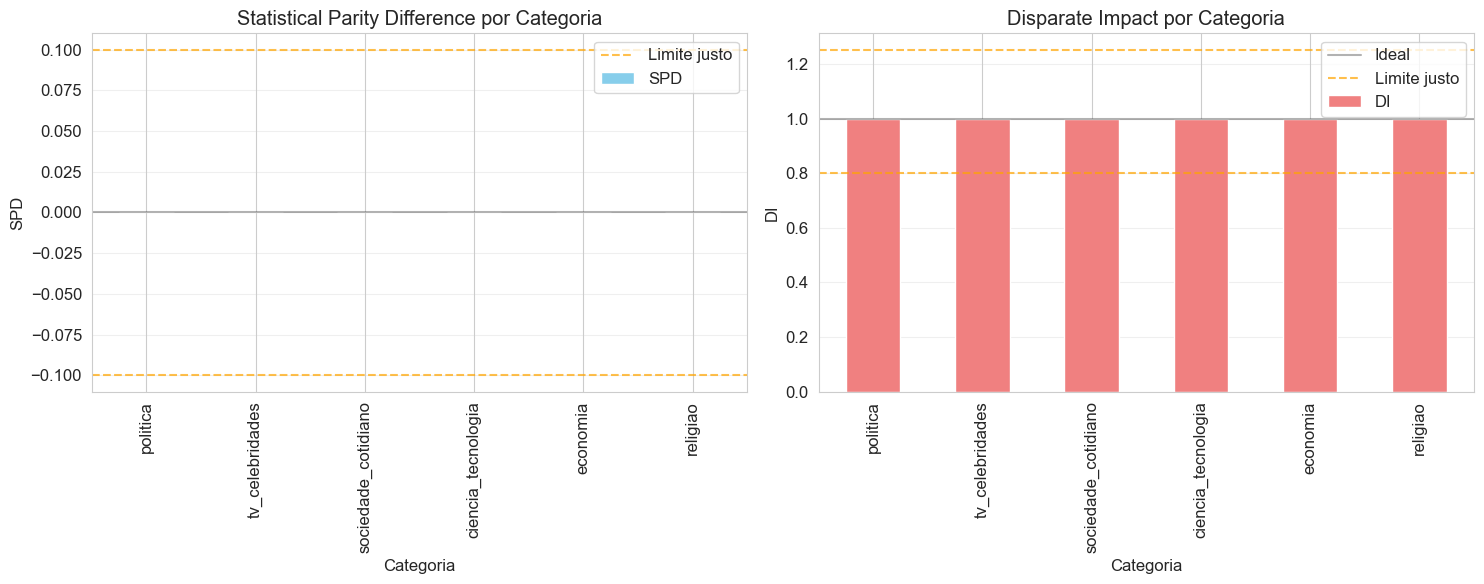


Tabela de Resultados:
                     SPD   DI
politica             0.0  1.0
tv_celebridades      0.0  1.0
sociedade_cotidiano  0.0  1.0
ciencia_tecnologia   0.0  1.0
economia             0.0  1.0
religiao             0.0  1.0


In [8]:
# Visualizar métricas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico SPD
fairness_df['SPD'].plot(kind='bar', ax=ax1, color='skyblue')
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax1.axhline(y=0.1, color='orange', linestyle='--', alpha=0.7, label='Limite justo')
ax1.axhline(y=-0.1, color='orange', linestyle='--', alpha=0.7)
ax1.set_title('Statistical Parity Difference por Categoria')
ax1.set_ylabel('SPD')
ax1.set_xlabel('Categoria')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Gráfico DI
fairness_df['DI'].plot(kind='bar', ax=ax2, color='lightcoral')
ax2.axhline(y=1.0, color='black', linestyle='-', alpha=0.3, label='Ideal')
ax2.axhline(y=1.25, color='orange', linestyle='--', alpha=0.7, label='Limite justo')
ax2.axhline(y=0.8, color='orange', linestyle='--', alpha=0.7)
ax2.set_title('Disparate Impact por Categoria')
ax2.set_ylabel('DI')
ax2.set_xlabel('Categoria')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar tabela de resultados
print("\nTabela de Resultados:")
print(fairness_df.round(3))

## 5. Salvamento dos Resultados

Salvar as métricas de fairness para uso posterior.

In [11]:
# Salvar resultados da análise de fairness
print("Salvando resultados da análise de fairness...")

# Usar o diretório reports existente
reports_dir = "../data/reports"
print(f"Usando diretório de reports: {reports_dir}")

# Salvar métricas em CSV
fairness_df.to_csv(f"{reports_dir}/fairness_metrics_fakebr.csv")
print("Métricas salvas em: ../data/reports/fairness_metrics_fakebr.csv")

# Salvar tabela cruzada
tabela_cruzada.to_csv(f"{reports_dir}/crosstab_categoria_label.csv")
print("Tabela cruzada salva em: ../data/reports/crosstab_categoria_label.csv")

# Salvar resumo textual
with open(f"{reports_dir}/fairness_summary.txt", "w", encoding="utf-8") as f:
    f.write("ANÁLISE DE FAIRNESS - DATASET FAKEBR\n")
    f.write("="*50 + "\n\n")
    
    f.write(f"Taxa geral de fake news: {taxa_geral_fake:.3f} ({taxa_geral_fake*100:.1f}%)\n\n")
    
    f.write("MÉTRICAS POR CATEGORIA:\n")
    f.write("-" * 30 + "\n")
    
    for categoria in fairness_df.index:
        spd_val = fairness_df.loc[categoria, 'SPD']
        di_val = fairness_df.loc[categoria, 'DI']
        f.write(f"{categoria}: SPD={spd_val:+.3f}, DI={di_val:.2f}\n")
    
    f.write(f"\nCategorias com possível viés:\n")
    problemas_encontrados = False
    for categoria in fairness_df.index:
        spd_val = fairness_df.loc[categoria, 'SPD']
        di_val = fairness_df.loc[categoria, 'DI']
        
        problemas = []
        if abs(spd_val) >= 0.2:
            problemas.append(f"SPD={spd_val:+.3f}")
        if di_val < 0.5 or di_val > 2.0:
            problemas.append(f"DI={di_val:.2f}")
        
        if problemas:
            f.write(f"  - {categoria}: {' | '.join(problemas)}\n")
            problemas_encontrados = True
    
    if not problemas_encontrados:
        f.write("Nenhuma categoria com viés alto detectada!\n")

print("Resumo textual salvo em: ../data/reports/fairness_summary.txt")

print(f"\nAnálise de Fairness Concluída!")
print(f"Todas as métricas DI/SPD calculadas")
print(f"Visualizações geradas") 
print(f"Resultados salvos em ../data/reports/")
print(f"\nPróximo passo: Execute o notebook 04_model_training.ipynb")

Salvando resultados da análise de fairness...
Usando diretório de reports: ../data/reports
Métricas salvas em: ../data/reports/fairness_metrics_fakebr.csv
Tabela cruzada salva em: ../data/reports/crosstab_categoria_label.csv
Resumo textual salvo em: ../data/reports/fairness_summary.txt

Análise de Fairness Concluída!
Todas as métricas DI/SPD calculadas
Visualizações geradas
Resultados salvos em ../data/reports/

Próximo passo: Execute o notebook 04_model_training.ipynb
